In [2]:
import torch
import random
import pyro
import torch.nn.functional as F
from configs import config
import networks
from activations import hidden_activation_dict, output_activation_dict
import scipy
import numpy as np
import matplotlib.pyplot as plt

ImportError: cannot import name 'config' from 'configs' (/Users/philipnielsen/Documents/Code/training_infra/training_infra/configs.py)

In [3]:
import go_benchmark

In [3]:
# network = torch.load('best_3x3_go_FC_architecture.p').to('cpu')
# state_dict = torch.load('best_3x3_go_FC_weights.p', map_location='cpu')
# network.load_state_dict(state_dict)
# model = lambda x: network(x)['alpha']

In [4]:
dataset_facts = {
    'CIFAR10':{
        'x_dimensions':(3,32,32), 
        'y_dimensions':(10,),
        'target_type': 'class_index'},
    'MNIST':{
        'x_dimensions': (1,28,28), 
        'y_dimensions':(10,),
        'target_type': 'class_index'}, 
    '5x5_go':{
        'x_dimensions': (18,5,5), 
        'y_dimensions':(26, 2),
        'target_type': 'dense_binomial_samples'},
    '3x3_go':{
        'x_dimensions': (18,3,3), 
        'y_dimensions':(10, 2),
        'target_type': 'dense_binomial_samples'}
    }
dataset_name = '3x3_go'
architecture_dict = {
    'FC': networks.FCNetwork,
    'CNN': networks.CNN,
    'BlockCNN': networks.BlockCNN
    }


In [13]:
a= [[1,2],[3,4]]
b = a[1] + [7]
b[0]+=1
print(b)
print(a)

[4, 4, 7]
[[1, 2], [3, 4]]


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else "cpu"))
network = architecture_dict[config['architecture']](hidden_act = hidden_activation_dict[config['hidden_activation']],
                                                    output_act = output_activation_dict[config['output_activation']],
                                                    width = config['network_width'],
                                                    depth = config['network_depth'],
                                                    input_dimensions=dataset_facts[dataset_name]['x_dimensions'],
                                                    output_dimensions=dataset_facts[dataset_name]['y_dimensions']
                                                    )
board_dim = 3
data, root, run_stats, solved = go_benchmark.create_go_dataset(10000, 10000, board_dimension=3, device=device)
while True:
    network = train(network.to(device), data, f'{board_dim}x{board_dim}_go_tests', using_wandb=False, config=config).to('cpu')
    model = lambda x: network(x)['alpha']
    go_benchmark.benchmark_network(model,3)
    data, root, run_stats, solved = go_benchmark.create_go_dataset(10000, 10000, run_stats=run_stats, root=root, network=model, device=device)
    if solved !=0:
        break

1
game move:  1
move choice: 1
winner:  None
chosen move: 9
[0]
[0, -8566791067245331815]
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])
game move:  2
move choice: 1
winner:  None
chosen move: 7
[0, -8566791067245331815]
[0, -8566791067245331815, 12533646668715114739]
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])
game move:  3
move choice: 1
move choice: 2
winner:  None
chosen move: 3
[0, -8566791067245331815, 12533646668715114739]
[0, -8566791067245331815, 12533646668715114739, -1295740760788660924]
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 1., 0.]]])
game move:  4
move choice: 1
winner:  None
chosen move: 9
[0, -8566791067245331815, 12533646668715114739, -1295740760788660924]
[0, -8566791067245331815, 1253364

KeyboardInterrupt: 

In [ ]:
go_benchmark.tree_explorer(root)

node solved: 1
children nodes solved: tensor([ 0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])
move wins: tensor([1., 0., 0., 1., 1., 0., 0., 0., 0., 0.])
move losses: tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 1.])
position wins: tensor(3.)
position losses: tensor(3.)
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
node solved: 1
children nodes solved: tensor([ 0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  1.])
move wins: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
move losses: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
position wins: tensor(1.)
position losses: tensor(0.)
tensor([[0., 0., 0.],
        [1., 0., 0.],
        [1., 1., 0.]])


ValueError: invalid literal for int() with base 10: ''

In [ ]:
run_stats

{'unique_nodes': 64304,
 'positions_visited': 136949,
 'transitions_observed': 72815}

In [ ]:
model = lambda x: network(x)['alpha']

In [ ]:
go_benchmark.benchmark_network(model,3)

1
unique_nodes 33374
positions_visited 82260
transitions_observed 37986


33374

In [ ]:
go_benchmark.benchmark_network(None,3)

1
unique_nodes 216192
positions_visited 427560
transitions_observed 242163


216192

In [14]:
def initialize_zobrist_tables(board_size):
    zobrist_table = [[random.randint(0, 2**64 - 1) for _ in range(2)] for _ in range(board_size * board_size)]
    zobrist_table_player = [random.randint(0, 2**64 - 1) for _ in range(2)]
    zobrist_pass = random.randint(0, 2**64 - 1)

    return {'table': zobrist_table, 'player': zobrist_table_player, 'pass': zobrist_pass}

def calculate_hash(board, current_player, last_hashes, zobrist, last_pass=False):
    zobrist_pass, zobrist_table, zobrist_table_player = zobrist['pass'], zobrist['table'], zobrist['player']
    board_size = board.size(1)
    new_last_hashes = [[]]*8
    for r in range(8):
        board_symmetry = torch.rot90(board, r, dims=(-1, -2))
        if r >=4:
            board_symmetry = torch.flip(board_symmetry, dims=(-1,))

        current_player_stones = board_symmetry[0].nonzero(as_tuple=False)
        opponent_stones = board_symmetry[1].nonzero(as_tuple=False)
    
        hash_value = 0
        for i, j in current_player_stones:
            hash_value ^= zobrist_table[i * board_size + j][0]
        for i, j in opponent_stones:
            hash_value ^= zobrist_table[i * board_size + j][1]

        board_hash = hash_value ^ zobrist_table_player[{'black':0,'white':1}[current_player]]
        if last_pass:
            board_hash ^= zobrist_pass
        
        new_last_hashes[r] = last_hashes[r] + [board_hash]

    return new_last_hashes

In [15]:
zobrist = initialize_zobrist_tables(3)

In [38]:
board = torch.zeros(2,3,3)
board[1,0,1] +=1
print(board)
last_hashes = calculate_hash(board, 'white', [[0]]*8, zobrist, last_pass=False)
# print(last_hashes)
# hash(tuple(sorted([frozenset(last_hashes_symmetry) for last_hashes_symmetry in last_hashes])))
print(hash(tuple(sorted([hash(frozenset(last_hashes_symmetry)) for last_hashes_symmetry in last_hashes]))))

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 1., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])
3610445015681519197


In [37]:
board = torch.zeros(2,3,3)
board[1,1,0] +=1
print(board)
last_hashes = calculate_hash(board, 'white', [[0]]*8, zobrist, last_pass=False)
# print(last_hashes)
print(hash(tuple(sorted([hash(frozenset(last_hashes_symmetry)) for last_hashes_symmetry in last_hashes]))))

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [1., 0., 0.],
         [0., 0., 0.]]])
3610445015681519197


In [41]:
if c != None:
    print('hi')
else:
    print('no')

NameError: name 'c' is not defined

In [43]:
a = [[]]*8

In [44]:
a[0] = a[0] + [1]
a

[[1], [], [], [], [], [], [], []]

In [48]:
hash(tuple(torch.tensor([1,2,3]).reshape(-1).tolist()))

529344067295497451

In [49]:
hash(tuple(torch.tensor([1,2,3]).reshape(-1).tolist()))

529344067295497451

In [52]:
torch.tensor([[1,2],[3,4]])[[(0,0),(1,0),(1,1)]]

IndexError: too many indices for tensor of dimension 2

In [60]:
list(zip(*[(0,0),(1,0),(1,1)]))

[(0, 1, 1), (0, 0, 1)]

In [59]:
removed_stones = [(0,0), (1,0)]
next_move = (1,1)
removed_stones + [next_move]
torch.tensor([[1,2],[3,4]])[list(zip(*removed_stones + [next_move]))]

tensor([1, 3, 4])

In [61]:
a = torch.randn(3,3,3)

In [62]:
a

tensor([[[-0.0409,  0.8201, -1.5337],
         [ 1.2555, -0.6753,  1.1442],
         [ 0.5113,  1.3721,  0.7800]],

        [[ 1.1804, -0.3127,  1.0293],
         [-1.5414, -2.9878,  0.6471],
         [ 1.9010, -0.2454, -0.5187]],

        [[ 1.5804,  1.3328,  0.9845],
         [ 0.3611,  0.9624,  1.6036],
         [ 1.1771, -1.8688,  0.3807]]])

In [66]:
a[-1:,[1,0]]

tensor([[[0.3611, 0.9624, 1.6036],
         [1.5804, 1.3328, 0.9845]]])

In [77]:
a = torch.randn(10,2)
print(a)
a[[1,3,7]] = torch.max(a[[1,3,7]],dim=0)[0]
print(a)

tensor([[ 1.2864, -1.4095],
        [-0.5513,  0.3467],
        [ 1.6652, -0.8593],
        [-1.2216, -0.6749],
        [-0.2306, -1.0725],
        [ 0.7972,  0.3881],
        [ 0.8009,  0.1275],
        [ 0.1081,  0.5397],
        [ 0.2310, -0.9922],
        [-0.5825,  0.9451]])
tensor([[ 1.2864, -1.4095],
        [ 0.1081,  0.5397],
        [ 1.6652, -0.8593],
        [ 0.1081,  0.5397],
        [-0.2306, -1.0725],
        [ 0.7972,  0.3881],
        [ 0.8009,  0.1275],
        [ 0.1081,  0.5397],
        [ 0.2310, -0.9922],
        [-0.5825,  0.9451]])


In [80]:
a[[1,3,7]]

tensor([[0.1081, 0.5397],
        [0.1081, 0.5397],
        [0.1081, 0.5397]])

In [76]:
torch.max(a[[1,3,7]],dim=0)[0]

tensor([ 0.3967, -0.0355])

In [129]:
dist = torch.distributions.beta.Beta(torch.tensor([.5]*10), torch.tensor([.5]*10))
probs = dist.sample()
posteriors = torch.zeros(10,2) +.5
for i in range(100):
    thompson_samples = torch.distributions.beta.Beta(posteriors[:,0], posteriors[:,1]).sample()
    chosen_move = thompson_samples.argmax()
    posteriors[chosen_move, int(1-torch.distributions.bernoulli.Bernoulli(probs=probs[chosen_move]).sample())] +=1
print(posteriors)
print(probs)

tensor([[14.5000,  1.5000],
        [ 0.5000,  1.5000],
        [39.5000,  0.5000],
        [ 0.5000,  2.5000],
        [ 9.5000,  2.5000],
        [ 5.5000,  3.5000],
        [ 0.5000,  1.5000],
        [ 0.5000,  1.5000],
        [16.5000,  2.5000],
        [ 3.5000,  1.5000]])
tensor([0.9840, 0.1671, 0.9999, 0.2338, 0.7895, 0.7099, 0.4927, 0.1960, 0.9545,
        0.9473])


In [145]:
a, b = 1., 2.

rng = np.random.default_rng()

x = scipy.stats.beta.rvs(a, b, size=1000, random_state=rng)

In [146]:
scipy.stats.beta.fit(x)

(1.028152957288958,
 2.0859027825738696,
 0.0003497339019646711,
 0.9976052412771994)

In [4]:
def beta_weighted_kl(alpha,weights):
    return scipy.special.betaln(*alpha) + alpha.dot(weights)

In [5]:
def get_nll_alpha(posteriors, weights):
    optimization_weights = weights.dot(scipy.special.digamma(posteriors.sum(axis=-1,keepdims=True)) - scipy.special.digamma(posteriors))
    nll_alpha = scipy.optimize.minimize(beta_weighted_kl, weights.dot(posteriors), args = (optimization_weights,))['x']
    return nll_alpha

In [6]:
def beta_weighted_mom(posteriors, weights):
    observations = posteriors.sum(axis=-1)
    means = posteriors[:,0]/observations
    variances = means*(1-means)/(1+observations)
    second_moments = variances + means**2
    fitted_mean = weights.dot(means)
    fitted_second_moment = weights.dot(second_moments)
    fitted_variance = fitted_second_moment - fitted_mean **2
    fitted_n = fitted_mean*(1-fitted_mean)/fitted_variance-1
    mom_alpha = np.array([fitted_mean, 1-fitted_mean])*fitted_n
    return mom_alpha

In [7]:
def cdf_mse(alpha, eval_points, true_cdf_values, eval_weights):
    return eval_weights.dot(np.square(scipy.stats.beta.ppf(eval_points, *alpha) - true_cdf_values))

probs
[0.1243 0.4548 0.29   0.6399 0.541  0.4571 0.5313 0.7056 0.9332 0.2222]
[[ 0.5  2.5]
 [ 1.5  2.5]
 [ 0.5  3.5]
 [ 4.5  3.5]
 [ 1.5  2.5]
 [ 0.5  2.5]
 [ 5.5  2.5]
 [ 3.5  3.5]
 [56.5  8.5]
 [ 1.5  2.5]]
weights
[0.003 0.017 0.    0.023 0.015 0.001 0.124 0.01  0.796 0.011]
[16.36388692  3.21856467]


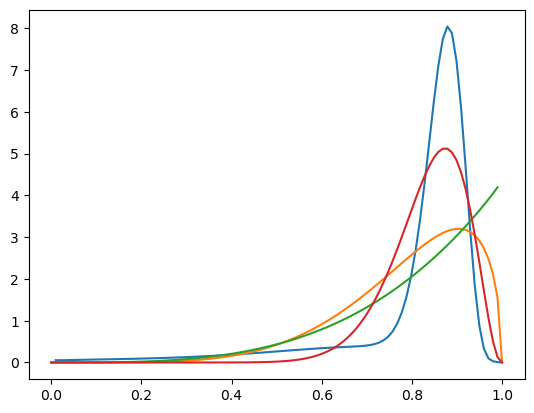

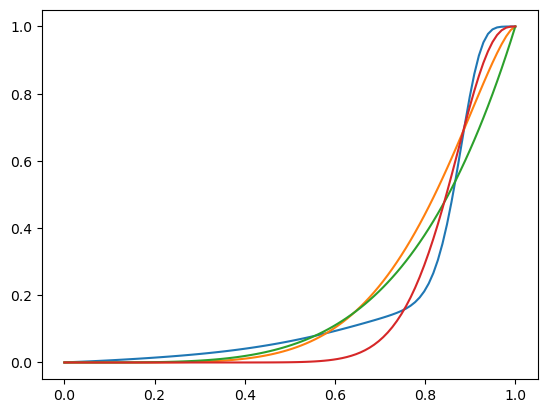

In [9]:
eval_points = np.random.random(1000)
probs = scipy.stats.beta.rvs(1, 1, size=10)
posteriors = np.zeros((10,2))+.5
print('probs')
print(probs.round(4))
for i in range(100):
    thompson_samples = scipy.stats.beta.rvs(posteriors[:,0], posteriors[:,1])
    chosen_move = thompson_samples.argmax()
    outcome = scipy.stats.bernoulli.rvs(probs[chosen_move])
    posteriors[chosen_move, 1-outcome] +=1
print(posteriors)
samples = scipy.stats.beta.rvs(posteriors[:,0], posteriors[:,1], size=(1000,10))
weights = (samples == samples.max(axis=1, keepdims=True)).mean(axis=0)
print('weights')
print(weights)

optimization_weights = weights.dot(scipy.special.digamma(posteriors.sum(axis=-1,keepdims=True)) - scipy.special.digamma(posteriors))
nll_alpha = scipy.optimize.minimize(beta_weighted_kl, weights.dot(posteriors), args = (optimization_weights,))['x']

observations = posteriors.sum(axis=-1)
means = posteriors[:,0]/observations
variances = means*(1-means)/(1+observations)
second_moments = variances + means**2
fitted_mean = weights.dot(means)
fitted_second_moment = weights.dot(second_moments)
fitted_variance = fitted_second_moment - fitted_mean **2
fitted_n = fitted_mean*(1-fitted_mean)/fitted_variance-1
mom_alpha = np.array([fitted_mean, 1-fitted_mean])*fitted_n

p = np.linspace(0,1,100)
pdfs = scipy.stats.beta.pdf(p, posteriors[:,[0]], posteriors[:,[1]])
cdfs = scipy.stats.beta.cdf(p, posteriors[:,[0]], posteriors[:,[1]])
true_pdf = weights.dot(pdfs)
true_cdf = weights.dot(cdfs)

true_cdf_values = np.interp(eval_points, true_cdf, p)
eval_weights = eval_points **10
eval_weights = eval_points/eval_points.sum()
cdf_mse_alpha = scipy.optimize.minimize(cdf_mse, weights.dot(posteriors), bounds = [(0,None), (0,None)], args = (eval_points, true_cdf_values, eval_weights))['x']
print(cdf_mse_alpha)

nll_pdf = scipy.stats.beta.pdf(p, *nll_alpha)
nll_cdf = scipy.stats.beta.cdf(p, *nll_alpha)
mom_pdf = scipy.stats.beta.pdf(p, *mom_alpha)
mom_cdf = scipy.stats.beta.cdf(p, *mom_alpha)
mse_pdf = scipy.stats.beta.pdf(p, *cdf_mse_alpha)
mse_cdf = scipy.stats.beta.cdf(p, *cdf_mse_alpha)
plt.plot(p, true_pdf)
plt.plot(p, nll_pdf)
plt.plot(p, mom_pdf)
plt.plot(p, mse_pdf)
plt.show()
plt.plot(p, true_cdf)
plt.plot(p, nll_cdf)
plt.plot(p, mom_cdf)
plt.plot(p, mse_cdf)


In [293]:
eval_points = np.random.random(100)
# eval_weights = scipy.stats.beta.ppf(eval_points,.5,.5)
eval_weights = eval_points**10
eval_weights = eval_weights/eval_weights.sum()
eval_weights
nll_errors = np.zeros((100,30))
mom_errors = np.zeros((100,30))
mse_errors = np.zeros((100,30))
weighted_nll_errors = np.zeros((100,30))
weighted_mom_errors = np.zeros((100,30))
weighted_mse_errors = np.zeros((100,30))

for n in range(100):
    print(n)
    for k in range(30):
        probs = scipy.stats.beta.rvs(.5, .5, size=10)
        posteriors = np.zeros((10,2))+.5
        for i in range(n):
            thompson_samples = scipy.stats.beta.rvs(posteriors[:,0], posteriors[:,1])
            chosen_move = thompson_samples.argmax()
            outcome = scipy.stats.bernoulli.rvs(probs[chosen_move])
            posteriors[chosen_move, 1-outcome] +=1
        samples = scipy.stats.beta.rvs(posteriors[:,0], posteriors[:,1], size=(1000,10))
        weights = (samples == samples.max(axis=1, keepdims=True)).mean(axis=0)

        optimization_weights = weights.dot(scipy.special.digamma(posteriors.sum(axis=-1,keepdims=True)) - scipy.special.digamma(posteriors))
        nll_alpha = scipy.optimize.minimize(beta_weighted_kl, weights.dot(posteriors), bounds = [(0,None), (0,None)], args = (optimization_weights,))['x']

        observations = posteriors.sum(axis=-1)
        means = posteriors[:,0]/observations
        variances = means*(1-means)/(1+observations)
        second_moments = variances + means**2
        fitted_mean = weights.dot(means)
        fitted_second_moment = weights.dot(second_moments)
        fitted_variance = fitted_second_moment - fitted_mean **2
        fitted_n = fitted_mean*(1-fitted_mean)/fitted_variance-1
        mom_alpha = np.array([fitted_mean, 1-fitted_mean])*fitted_n
        
        

        p = np.linspace(0,1,100)
        cdfs = scipy.stats.beta.cdf(p, posteriors[:,[0]], posteriors[:,[1]])
        true_cdf = weights.dot(cdfs)
        true_cdf_values = np.interp(eval_points, true_cdf, p)
        
        
        
        nll_cdf = scipy.stats.beta.cdf(p, *nll_alpha)
        mom_cdf = scipy.stats.beta.cdf(p, *mom_alpha)
        

        
        nll_cdf_values = np.interp(eval_points, nll_cdf, p)
        errors = np.square((true_cdf_values - nll_cdf_values))
        nll_errors[n,k] = errors.mean()
        weighted_nll_errors[n,k] = eval_weights.dot(errors)
        mom_cdf_values = np.interp(eval_points, mom_cdf, p)
        errors = np.square((true_cdf_values - mom_cdf_values))
        mom_errors[n,k] = errors.mean()
        weighted_mom_errors[n,k] = eval_weights.dot(errors)

        
        cdf_mse_alpha = scipy.optimize.minimize(cdf_mse, weights.dot(posteriors), bounds = [(0,None), (0,None)], args = (eval_points, true_cdf_values, eval_weights))['x']
        mse_cdf = scipy.stats.beta.cdf(p, *cdf_mse_alpha)
        mse_cdf_values = np.interp(eval_points, mse_cdf, p)
        errors = np.square((true_cdf_values - mse_cdf_values))
        weighted_mse_errors[n,k] = eval_weights.dot(errors)
        
        cdf_mse_alpha = scipy.optimize.minimize(cdf_mse, weights.dot(posteriors), bounds = [(0,None), (0,None)], args = (eval_points, true_cdf_values, np.ones(len(eval_points))/len(eval_points)))['x']
        mse_cdf = scipy.stats.beta.cdf(p, *cdf_mse_alpha)
        mse_cdf_values = np.interp(eval_points, mse_cdf, p)
        errors = np.square((true_cdf_values - mse_cdf_values))
        mse_errors[n,k] = errors.mean()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


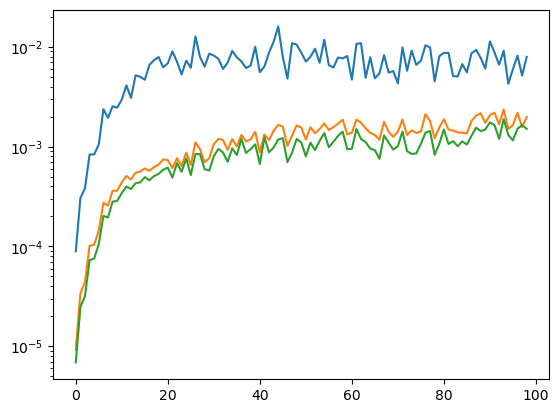

In [295]:
plt.plot(np.nanmean(nll_errors,axis=-1)[1:])
plt.plot(mom_errors.mean(axis=-1)[1:])
plt.plot(mse_errors.mean(axis=-1)[1:])
plt.yscale('log')

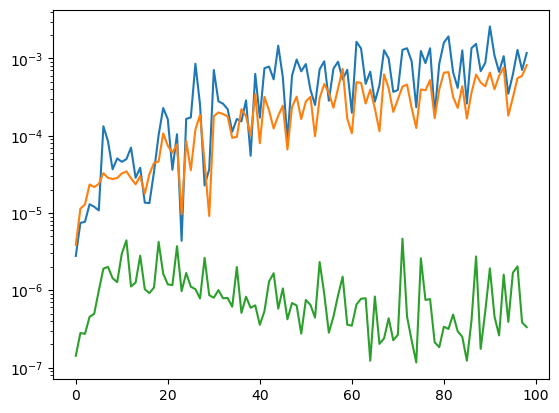

In [298]:
plt.plot(np.nanmean(weighted_nll_errors,axis=-1)[1:])
plt.plot(weighted_mom_errors.mean(axis=-1)[1:])
plt.plot(weighted_mse_errors.mean(axis=-1)[1:])
plt.yscale('log')

In [233]:
np.nanmean(nll_errors)

0.00432365204442579

In [254]:
%timeit beta_weighted_mom(posteriors, weights)

5.18 µs ± 133 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [256]:
%timeit get_nll_alpha(posteriors, weights)

1.03 ms ± 5.01 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [259]:
alpha = np.array([3,4])

In [261]:
eval_points = np.random.random(1000)

In [263]:
true_cdf_values = np.interp(eval_points, true_cdf, p)
true_cdf_values

array([9.93820885e-01, 9.96737024e-01, 9.70098425e-01, 9.99440201e-01,
       9.97939872e-01, 9.62469136e-01, 9.96404031e-01, 9.97845683e-01,
       9.93466749e-01, 9.93039623e-01, 9.91317923e-01, 9.95136748e-01,
       9.90954945e-01, 9.81701577e-01, 9.85187267e-01, 9.94618763e-01,
       9.89969722e-01, 9.70795533e-01, 9.73701635e-01, 9.74591209e-01,
       9.94526490e-01, 9.81803018e-01, 9.63637228e-01, 9.82924202e-01,
       9.92109846e-01, 9.84156616e-01, 9.92329786e-01, 9.75166335e-01,
       9.95366514e-01, 9.21628467e-01, 9.94208154e-01, 9.93252938e-01,
       9.90365730e-01, 9.93102593e-01, 9.99048132e-01, 9.91380261e-01,
       9.80950246e-01, 9.84050905e-01, 9.75340109e-01, 9.85331427e-01,
       9.96154571e-01, 9.64000112e-01, 9.97830609e-01, 9.74302337e-01,
       9.91274719e-01, 9.97279564e-01, 9.82843747e-01, 9.62681257e-01,
       9.95786202e-01, 9.99169168e-01, 9.93154612e-01, 9.91926300e-01,
       9.98154223e-01, 9.90422964e-01, 9.83037041e-01, 9.18669676e-01,
      

In [ ]:
scipy.optimize.minimize(cdf_mse, weights.dot(posteriors), args = (eval_points, true_cdf_values))['x']

In [299]:
torch.cat([1,2,3])

TypeError: expected Tensor as element 0 in argument 0, but got int

In [302]:
[1,2,3,4][1:2]

[2]

In [71]:
import torch

class Buffer:
    def __init__(self, test_capacity, train_capacity, board_dim=3):
        self.test_capacity = test_capacity
        self.train_capacity = train_capacity
        self.test_list = []
        self.train_list = []
        
        self.dataset = {
            'Train': {
                'x':torch.zeros((0, 18, board_dim, board_dim)), 
                'y': torch.zeros((0, board_dim **2 + 1, 2), dtype=torch.int64)
                },
            'Test': {
                'x':torch.zeros((0, 18, board_dim, board_dim)), 
                'y': torch.zeros((0, board_dim **2 + 1, 2), dtype=torch.int64)
                }
        }
        
        self.hash_map = {
            'Train': {},
            'Test': {}
        }
    
    def get_dataset(self, device):
        test_excess = self.test_list[:-self.test_capacity]
        self.test_list = self.test_list[-self.test_capacity:]
        
        self.train_list = self.train_list + test_excess
        
        train_excess = self.train_list[:-self.train_capacity]
        self.train_list = self.train_list[-self.train_capacity:]
        
        for position_hash, move_outcome, x in test_excess:
            self._increment_dataset(position_hash, move_outcome, x, -1, 'Test')
            self._increment_dataset(position_hash, move_outcome, x, 1, 'Train')
        
        for position_hash, move_outcome, x in train_excess:
            self._increment_dataset(position_hash, move_outcome, x, -1, 'Train')

        self._remove_empty_data()
        
        return {split: {k: v.to(device) for k, v in dataset.items()} for split, dataset in self.dataset.items()}

    def add_data(self, data):
        self.test_list = self.test_list + data
        for position_hash, move_outcome, x in data:
            self._increment_dataset(position_hash, move_outcome, x, 1, 'Test')
    
    def _remove_empty_data(self):
        for split in ['Test', 'Train']:
            nonempty_indices = ~(self.dataset[split]['y']==0).all(dim=(-1,-2))
            new_indices = torch.cumsum(nonempty_indices, dim=0)-1
            for k, v in list(self.hash_map[split].items()):
                if nonempty_indices[v]:
                    self.hash_map[split][k] = new_indices[v]
                else:
                    del self.hash_map[split][k]
            self.dataset[split]['y'] = self.dataset[split]['y'][nonempty_indices]
            self.dataset[split]['x'] = self.dataset[split]['x'][nonempty_indices]

    def _increment_dataset(self, position_hash, move_outcome, x, increment, split):
        if position_hash not in self.hash_map[split]:
            self.hash_map[split][position_hash] = len(self.dataset[split]['y'])
            self.dataset[split]['y'] = torch.cat((self.dataset[split]['y'], torch.zeros((1, 10, 2), dtype=torch.int64)), dim=0)
            self.dataset[split]['x'] = torch.cat((self.dataset[split]['x'], x.unsqueeze(0)), dim=0)
        
        index = self.hash_map[split][position_hash]
        self.dataset[split]['y'][index][move_outcome] += increment

    def size(self):
        return {'Train': len(self.train_list), 'Test': len(self.test_list)}


In [97]:
buffer = Buffer(10000,20000)
# buffer.add_data([(1,(7,1), torch.randn(18,3,3)), 
#                  (2,(2,0), torch.randn(18,3,3)), 
#                  (1,(3,1), torch.randn(18,3,3)), 
#                  (3,(5,1), torch.randn(18,3,3)), 
#                  (2,(9,0), torch.randn(18,3,3)), 
#                  (2,(1,1), torch.randn(18,3,3))])
buffer.add_data([(random.randrange(0,100), (random.randrange(0,10), random.randrange(0,2)), torch.randn(18,3,3)) for _ in range(30)])
# buffer.get_dataset('mps')

In [73]:
buffer.size()

{'Train': 3, 'Test': 2}

In [74]:
buffer.hash_map

{'Train': {1: tensor(0), 2: tensor(1), 3: tensor(2)}, 'Test': {2: tensor(0)}}

In [81]:
%timeit buffer.get_dataset('mps')

527 µs ± 36.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [82]:
%timeit buffer.add_data(data)

4.42 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [98]:
!pip install pyspiel

ERROR: Could not find a version that satisfies the requirement pyspiel (from versions: none)
ERROR: No matching distribution found for pyspiel


In [99]:
a = [0,2,3,4,5]
%timeit a[2] +=1

30.5 ns ± 0.528 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [101]:
import numpy as np

In [142]:
a = np.array([0,2,3,4,5])
%timeit a[2] +=1

94.8 ns ± 1.86 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [139]:
a = torch.tensor([0,2,3,4,5])
%timeit a[2] +=1

2.33 µs ± 58.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [106]:
a = [0,2,3,4,5,6]
%timeit a[4] +=1

29.2 ns ± 0.92 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [138]:
a = [[0,2,3],[4,5,6]]
%timeit a[1][1] +=1

30.5 ns ± 2.66 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [109]:
[[0]*10]*2

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [111]:
[[0,2,3],[4,5,6]][0]

[0, 2, 3]

In [115]:
a = torch.tensor([[1.,2.],[3.,4.]])
%timeit pyro.distributions.Beta(*a).sample()

37.6 µs ± 1.72 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [118]:
a = np.array([[1.,2.],[3.,4.]])
%timeit pyro.distributions.Beta(*torch.tensor(a)).sample()

38.5 µs ± 3.07 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [119]:
a = [[1.,2.],[3.,4.]]
%timeit pyro.distributions.Beta(*torch.tensor(a)).sample()

40.8 µs ± 2.52 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [121]:
a = np.array([[1.,2.,3.,4.,5.,6.,7.,8.,9.,10.],[3.,4.,5.,6.,7.,8.,9.,10.,11.,12.]])
preds = torch.tensor([[5.,6.,7.,8.,9.,10.,11.,12.,13.,14.],[7.,8.,9.,10.,11.,12.,13.,14.,15.,16.]])
%timeit pyro.distributions.Beta(*(torch.tensor(a)+preds)).sample()

40.6 µs ± 1.3 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [123]:
%timeit (torch.tensor(a)+preds)

3.75 µs ± 464 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [132]:
a = np.array([[1,2],[3,4]])
%timeit a[0,0] +=1

116 ns ± 1.54 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [133]:
a = np.array([0,2,3,4,5])
%timeit a[2] +=1

95.3 ns ± 1.46 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [134]:
np.array([[1,2],[3,4],[5,6]])[[1,2]]

array([[3, 4],
       [5, 6]])

In [137]:
np.vstack((np.array([[1,2],[3,4],[5,6]]),np.array([[1,2],[3,4],[5,6]])))

array([[1, 2],
       [3, 4],
       [5, 6],
       [1, 2],
       [3, 4],
       [5, 6]])

In [141]:
a = np.array([[1,2],[3,4]])
%timeit a[1] += np.array([4,7])

550 ns ± 18.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [143]:
a = torch.tensor([[1,2],[3,4]])
%timeit a[1] += torch.tensor([4,7])

3.83 µs ± 312 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [144]:
a = np.array([[1,2],[3,4]])
%timeit torch.tensor(a)

1.93 µs ± 13.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [147]:
a = np.array([[1,2],[3,4]])
%timeit np.vstack((a, np.zeros((10,2))))

1.17 µs ± 2.34 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [148]:
a = [[1,2],[3,4]]
%timeit np.array(a)

410 ns ± 9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [149]:
a = [[1,2],[3,4]]
%timeit a.extend([[0]*2]*10)

120 ns ± 1.26 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [151]:
a = torch.tensor([[1,2],[3,4]], device='mps')
%timeit a[0][0] +=1

29.4 µs ± 4.4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [152]:
a = torch.tensor([[1,2],[3,4]], device='cpu')
%timeit a[0][0] +=1

3.1 µs ± 113 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [153]:
%timeit a.to('mps')

145 µs ± 42.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [156]:
a = torch.tensor([[1,2],[3,4]], device='cpu')
a.to('mps')

tensor([[1, 2],
        [3, 4]], device='mps:0')

In [157]:
def f():
    a = torch.tensor([[1,2],[3,4]], device='cpu')
    a.to('mps')


In [158]:
%timeit f()

114 µs ± 2.4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [160]:
%timeit torch.tensor([[1,2],[3,4]], device='mps')



109 µs ± 2.03 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [162]:
%timeit torch.tensor([[1,2],[3,4]])

2.17 µs ± 147 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [163]:
a = torch.tensor([[1,2],[3,4]])
%timeit a[0,0] +=1

3.9 µs ± 229 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [164]:
a = [[1,2],[2,3],[4,5]]
a[[0,1]]

TypeError: list indices must be integers or slices, not list

In [165]:
a = np.array([[1,2],[2,3],[4,5]])
%timeit a.tolist()

104 ns ± 0.117 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [166]:
a = [[1,2],[2,3],[4,5]]
%timeit np.array(a)

547 ns ± 34.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [167]:
a = np.array([[1,2],[2,3],[4,5]])
%timeit torch.tensor(a)

1.92 µs ± 8.54 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [170]:
np.array([[1,2],[2,3],[4,5]]).all(axis=(0,1))

True

In [171]:
torch.tensor([np.array([[1,2],[2,3],[4,5]]),np.array([[1,2],[2,3],[4,5]])])

/var/folders/y3/v5bw1qds23152m_g_1tzz7q80000gn/T/ipykernel_14364/3158492159.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  torch.tensor([np.array([[1,2],[2,3],[4,5]]),np.array([[1,2],[2,3],[4,5]])])


tensor([[[1, 2],
         [2, 3],
         [4, 5]],

        [[1, 2],
         [2, 3],
         [4, 5]]])

In [185]:
a = torch.tensor([[1,2],[2,3],[4,5]],dtype=torch.float32)
%timeit pyro.distributions.Dirichlet(a).sample()[:,0]

18.9 µs ± 154 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [183]:
a = torch.tensor([[1,2],[2,3],[4,5]],dtype=torch.float32)
%timeit pyro.distributions.Beta(*a.transpose(0,1)).sample()

40.9 µs ± 3.25 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [184]:
pyro.distributions.Beta(*a.transpose(0,1)).sample()

tensor([0.3419, 0.7778, 0.6876])

In [196]:
a=torch.tensor([[.5,.5],[.5,.5],[.5,.5]])
pyro.distributions.Beta(*a.transpose(0,1)).sample()

tensor([0.9868, 0.7496, 0.0010])

In [197]:
pyro.distributions.Dirichlet(a).sample()

tensor([[0.0770, 0.9230],
        [0.4323, 0.5677],
        [0.0350, 0.9650]])

In [199]:
a.transpose(0,1)



tensor([[0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000]])

In [200]:
a

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000]])

In [4]:
[1,3] in [[1,2],[3,4]]

False

In [8]:
%timeit torch.tensor((1,2))

1.61 µs ± 22.4 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [9]:
%timeit torch.tensor([1,2])

1.62 µs ± 7.36 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [17]:
a = list(range(4*3*3))

In [18]:
%timeit tuple(a)

52.1 ns ± 0.478 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [20]:
b = tuple(a)

In [21]:
torch.tensor(b)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])

In [26]:
%timeit torch.tensor(b)

4.07 µs ± 72.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [23]:
%timeit torch.tensor(a)

4.06 µs ± 64.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [25]:
%timeit hash(b)

77.3 ns ± 0.625 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [30]:
a = np.array([0]*10)

In [31]:
%timeit a.any()

597 ns ± 5.4 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [32]:
b = np.array([1]*10)
%timeit b.all()

600 ns ± 4.69 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [34]:
a = [1,1,1,1,1,1,1,1,1,1]
%timeit any(x==1 for x in a)

193 ns ± 4.47 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [36]:
b = [0,0,0,0,0,0,0,0,0,0]
%timeit all(x == 0 for x in b)

315 ns ± 3.16 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [38]:
b = [0,0,0,0,0,0,0,0,0,0]
all(x == 0 for x in b)

True

In [39]:
[1,2,3][set([0])]

TypeError: list indices must be integers or slices, not set

In [40]:
len(set([None,0]))

2

In [41]:
a = [[1,2],[3,4]]
%timeit a[0][1] +=1

31.6 ns ± 0.378 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [45]:
a = torch.tensor([[1,2],[3,4],[6,7]], device='mps')
%timeit a[0,1] +=1

32.9 µs ± 3.32 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [47]:
%timeit a = torch.tensor([[1,2],[3,4],[6,7],[1,2],[3,4],[6,7],[1,2],[3,4],[6,7]], device='mps')

123 µs ± 862 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [48]:
torch.tensor([(1,2),(3,4)])

tensor([[1, 2],
        [3, 4]])

In [49]:
a = [[1,2],[3,4]]

In [50]:
b = a

In [51]:
a = []

In [52]:
b

[[1, 2], [3, 4]]

In [53]:
a = {'hi': []}
b = a['hi']
b.append(1)
a

{'hi': [1]}

In [61]:
def go_size(n,k):
    return scipy.special.loggamma(n**2+1) - 2*scipy.special.loggamma(k/2+1) - scipy.special.loggamma(n**2-k+1)

In [71]:
board_dim = 3
num_pos = np.array([go_size(board_dim,i) for i in range(board_dim**2+1)])
print('approx num leaves:', round(np.exp(num_pos[-1])))
print(num_pos)
print(np.exp(np.diff(num_pos)))

approx num leaves: 132
[0.         2.43878905 4.27666612 5.65321053 6.62804138 7.22182645
 7.42654907 7.20120716 6.44571982 4.88619954]
[11.4591559   6.28318531  3.96118969  2.6507188   1.81082957  1.22718463
  0.79824324  0.46978162  0.2102369 ]


In [72]:
board_dim = 4
num_pos = np.array([go_size(board_dim,i) for i in range(board_dim**2+1)])
print('approx num leaves:', round(np.exp(num_pos[-1])))
print(num_pos)
print(np.exp(np.diff(num_pos)))

approx num leaves: 12870
[ 0.          3.0141532   5.48063892  7.55033051  9.29835125 10.76760506
 11.98392859 12.96255948 13.71114954 14.23107081 14.51762541 14.55924424
 14.33530385 13.81137216 12.9283902  11.57332559  9.4626543 ]
[20.37183272 11.78097245  7.92237939  5.74322407  4.34599098  3.37475773
  2.6608108   2.11401727  1.68189522  1.33183088  1.04249704  0.79936278
  0.59218767  0.41354789  0.25793063  0.12115661]


In [73]:
board_dim = 5
num_pos = np.array([go_size(board_dim,i) for i in range(board_dim**2+1)])
print('approx num leaves:', round(np.exp(num_pos[-1])))
print(num_pos)
print(np.exp(np.diff(num_pos)))

approx num leaves: 5301248
[ 0.          3.4604403   6.39692966  8.96305813 11.23717196 13.26604156
 15.0802021  16.70068687 18.14242411 19.41611718 20.52935035 21.48725992
 22.29293895 22.94766225 23.45097465 23.80065814 23.99257194 24.02033548
 23.8747889  23.54310357 23.00728833 22.24155044 21.20723006 19.84176302
 18.02917623 15.48345291]
[31.83098862 18.84955592 13.01533757  9.71930227  7.60548421  6.13592315
  5.05554053  4.22803455  3.57402735  3.04418487  2.6062426   2.23821579
  1.92460992  1.65419155  1.41861846  1.21156608  1.02815254  0.86454962
  0.71771313  0.58519202  0.46499069  0.35546788  0.25526143  0.16323135
  0.07841631]


In [77]:
state.apply_action(16)

In [78]:
print(state)

GoState(komi=1.5, to_play=W, history.size()=1)

 4 ++++
 3 ++++
 2 ++++
 1 ++++
   ABCD



In [79]:
state.apply_action(16)

In [80]:
print(state)

GoState(komi=1.5, to_play=B, history.size()=2)

 4 ++++
 3 ++++
 2 ++++
 1 ++++
   ABCD



In [81]:
state.is_terminal()

True

In [82]:
state.current_player()

-4

In [85]:
%load_ext memory_profiler



The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 198.98 MiB, increment: 9.81 MiB


In [86]:
%memit list(range(10**6))

peak memory: 206.78 MiB, increment: 7.69 MiB


In [87]:
%memit np.array(range(10**6))

peak memory: 223.44 MiB, increment: 15.42 MiB


In [88]:
import sys

In [89]:
sys.getsizeof(torch.randn(10,2))

88

In [91]:
sys.getsizeof(tuple(range(4*4*4)))

552

In [92]:
sys.getsizeof(hash(tuple(range(4*4*4))))

36

In [93]:
a = tuple(range(4*4*4))
%timeit hash(a)

134 ns ± 0.339 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [96]:
%timeit state.observation_tensor()

666 ns ± 12.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [97]:
d = {'k': tuple(range(4*4*4))}

In [98]:
%timeit d['k']

11.8 ns ± 0.0274 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [99]:
d[a] = tuple(range(4*4*4))

In [100]:
%timeit d[a]

130 ns ± 0.208 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [101]:
hash(list(range(4*4*4)))

TypeError: unhashable type: 'list'

In [108]:
bitlist = state.observation_tensor()

def f(bitlist):
    out = 0
    for bit in bitlist:
        out = (out << 1) | round(bit)
    return out
%timeit f(bitlist)

3.5 µs ± 32.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [109]:
%timeit hash(tuple(bitlist))

417 ns ± 7.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [110]:
bitlist = [int(x) for x in bitlist]
def f(bitlist):
    out = 0
    for bit in bitlist:
        out = (out << 1) | bit
    return out
%timeit f(bitlist)

1.65 µs ± 32.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [113]:
%timeit int("".join(str(i) for i in bitlist),2)

3.53 µs ± 88.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [115]:
from functools import reduce

In [117]:
%timeit reduce(lambda acc, bit: (acc << 1) | bit, bitlist, 0)

2.94 µs ± 74.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [118]:
sys.getsizeof([[0]*2 for _ in range(10)])

184

In [119]:
sys.getsizeof([])

56

In [121]:
a = [[0]*2 for _ in range(10)]
a[0][0]+=1
a

[[1, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0]]

In [151]:
posteriors = (10*torch.randn(10,2))**2

In [152]:
%timeit torch.distributions.dirichlet.Dirichlet(posteriors).sample()[:, 0].argmax()

22.8 µs ± 2.51 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [155]:
%timeit torch.distributions.beta.Beta(*posteriors.transpose(0,1))

28.8 µs ± 1.17 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [140]:
%memit a = torch.distributions.dirichlet.Dirichlet(posteriors).sample()[:, 0].argmax()

peak memory: 216.83 MiB, increment: 0.00 MiB


In [141]:
%timeit pyro.distributions.Dirichlet(posteriors).sample()[:, 0].argmax()

22.7 µs ± 2.34 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [143]:
%memit a = pyro.distributions.Dirichlet(posteriors).sample()[:, 0].argmax()

peak memory: 216.83 MiB, increment: 0.00 MiB


In [144]:
sys.getsizeof(True)

28

In [1]:
from bitarray import bitarray

In [153]:
observation_tensor = tuple(state.observation_tensor())
bits = bitarray([int(x) for x in observation_tensor])
print(bits)

bitarray('0000000000000000000000000000000011111111111111110000000000000000')


In [154]:
sys.getsizeof(bits)

88

In [155]:
sys.getsizeof(observation_tensor)

552

In [156]:
sys.getsizeof(bitarray())

80

In [162]:
hash(bits)

TypeError: unhashable type: 'bitarray.bitarray'

In [164]:
bitarray(np.array(observation_tensor).reshape(4,4,4))

TypeError: only integer scalar arrays can be converted to a scalar index

In [169]:
b = bitarray()

In [167]:
b.extend([1,0,0,1])

In [168]:
b

bitarray('1001')

In [6]:
import pyspiel
import sys
from bitarray import bitarray
game = pyspiel.load_game('go', {'board_size': 4, 'komi':1.5})
state = game.new_initial_state()

In [4]:
observation_tensor = tuple(state.observation_tensor())
observation_hash = hash(observation_tensor)
action = 7
winner = 0

In [5]:
print('observation_tensor size: ', sys.getsizeof(observation_tensor))
print('observation_hash size: ', sys.getsizeof(observation_hash))
print('action size: ', sys.getsizeof(action))
print('winner size: ', sys.getsizeof(winner))

observation_tensor size:  552
observation_hash size:  32
action size:  28
winner size:  28


In [85]:
board_dim = 4
num_possible_moves = board_dim**2+1
bits_per_int = int(math.ceil(math.log2(num_possible_moves)))
action_bit_dict = {i: bitarray(f'{i:0{bits_per_int}b}') for i in range(num_possible_moves)}
count_bit_dict

In [86]:
a = bitarray()
actions = [random.randrange(num_possible_moves) for _ in range(10)]
a.encode(action_bit_dict, actions)
a

bitarray('01101010110001001000000000101100111010100110100010')

In [87]:
a.decode(action_bit_dict)

[13, 11, 2, 8, 0, 11, 7, 10, 13, 2]

In [106]:
from bitarray.util import int2ba, ba2int, vl_encode, vl_decode

In [109]:
a = bitarray('100110101')
data = vl_encode(a)
stream = iter(data)
print(vl_decode(stream))
stream = iter(data)
print(vl_decode(stream))

bitarray('100110101')
bitarray('100110101')


In [99]:
bitarray([int2ba(random.randrange(1000000), length=20) for _ in range(7)])

TypeError: 'bitarray.bitarray' object cannot be interpreted as an integer

In [36]:
import math

In [41]:
b = bitarray([1])

In [43]:
b.encode(action_bit_dict,[7])

In [45]:
b

bitarray('100111')

In [46]:
b.append(1)

In [47]:
b.extend

bitarray('1001111')

In [50]:
torch.FloatTensor(bitarray([0,1,0]))

tensor([0., 1., 0.])

In [51]:
a= bitarray([0,1,1,1,0,1,0,1])

In [54]:
a.search(bitarray([0,1]))

[0, 4, 6]

In [56]:
a.extend(bitarray([0,1]))

In [57]:
a

bitarray('0111010101')

In [58]:
b

bitarray('1001111')

In [59]:
b.encode(action_bit_dict,7)

TypeError: 'int' object is not iterable

In [60]:
a = [[0,0]]*10
a

[[0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0]]

In [61]:
a[0][0]+=1

In [62]:
a

[[1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0]]

In [63]:
[1,2,3].index(3)

2

In [66]:
[bitarray([0,1]),bitarray([1,0])].index(bitarray([2,0]))

ValueError: bit must be 0 or 1, got 2

In [68]:
int(bitarray([0,1]))

ValueError: invalid literal for int() with base 10: b'p'

In [69]:
from bitarray.util import vl_encode

In [83]:
a = bitarray('0110001111')
b = bitarray('001')
data = vl_encode(a) + vl_encode(b) + vl_encode(a)

In [79]:
data

b'\x96\x1e\x12\x96\x1e'

In [80]:
list(data)

[150, 30, 18, 150, 30]

In [82]:
[x for x in enumerate(data)]

[(0, 150), (1, 30), (2, 18), (3, 150), (4, 30)]

In [84]:
action_bit_dict = {i: bitarray(f'{i:0{self.bits_per_action}b}') for i in range(self.num_possible_moves)}

NameError: name 'self' is not defined

In [110]:
str([1,1,1])

'[1, 1, 1]'

In [112]:
''.join([1,1,1])

TypeError: sequence item 0: expected str instance, int found

In [115]:
str((1,1,1))

'(1, 1, 1)'

In [118]:
d = {i: bitarray(f'{i:0{20}b}') for i in range(1000000)}


bitarray('011000000011110010111000010000001101100000000000110110101101010011101101111010001001000101000100010111101011101000010110100100001100000101011101110010110001011010011011010110010111010101000100011011000110010001001101100101101000001101010100100011101000001010011101000000100011000011011000110100101110100110000111101101000111000101101000101111100000110000111000011001011110100000001100011100011011101010110000010110001110010111111110001111000000110001011010100001111011101010010111000101000010001011011011011110111110011111100101101110100001000000011010001000000000101011101100001000010100111100101001010110111101010001011100001110000111000000101000111011111001100011110010010011011000100110000001100110100010000100000000111100101001000100001111000110101111101111100110111010000110100101000000001100110010101101101110000110001001000111000001010111000001010000000010011110111001010011010110110101011100000101100001110101101111000110010110111101101101010000100110011110010010110101011010111100

In [122]:
a = bitarray()
a.encode(d, [random.randrange(1000000) for _ in range(100)])
print(a)
%timeit a.decode(d)

bitarray('011001010010001011001011010100010110000010110100111010110011100001101101000100001001001001001001010010110111000110011000101100111001011110010100010010111010111110010010110010101110101010111110111010100010011110001001101111000100110000010001000101110110110101100000101111111111000110110000001010010110101011000101000101111010001101101111101000010110001011110100110101010000010101010111111110100111101001100010111100001000011111001100001000111101101001001010110010111110111110110110011011111111110110111100110111101110110000111001010101100110110101010111111111000101000111100001011000000101011000101100010011001111101000100101010000111000111101110001010011101110011100100110011110101001010100001101000010110010000111010010101011001111011000111101111110010001001110110111110011100111110010110001100010110000110000111111000110100110001111011100011001110110001011101110101011110001110111001000001110000001010101001010010111101010010110111110100000001101011010100100011010110111111101011011110111

In [127]:
sys.getsizeof(np.zeros(1000000000))

8000000112

In [129]:
sys.getsizeof([0]*1000000000)

8000000056

In [130]:
sys.getsizeof([0]*2)

72

In [138]:
a = bitarray([1,0,1,0,0,0,0,1,0,0,1,1,1,0,1,1,1,1,1,1])
%timeit torch.FloatTensor(a)

3.08 µs ± 42.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [139]:
%timeit torch.FloatTensor([1,0,1,0,0,0,0,1,0,0,1,1,1,0,1,1,1,1,1,1])

2.22 µs ± 21 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [141]:
sys.getsizeof(np.zeros((100,100)))

80128

In [142]:
sys.getsizeof([[0 for _ in range(100)] for _ in range(100)])

920

In [143]:
sys.getsizeof([0 for _ in range(10000)])

85176

In [144]:
a = [[0 for _ in range(100)] for _ in range(100)]

In [145]:
a[0][0]+=1

In [148]:
sys.getsizeof([0,0])

72

In [149]:
sys.getsizeof([0,0,0])

88

In [6]:
a = torch.tensor([1,2], device='mps')
b = torch.tensor([1,2], device='cpu')

In [10]:
b = b.to(a.device)

In [11]:
b.device

device(type='mps', index=0)

In [29]:
torch.bincount(pyro.distributions.Dirichlet(torch.tensor([[1.,2.],[3.,4.],[5.,6.]])).sample([100])[:,:,0].argmax(axis=-1))

tensor([19, 33, 48])

In [35]:
def MOSSEindices(posteriors, player):
    """ Compute the current indexes for all arms, in a vectorized manner."""
    t = posteriors.sum()
    pulls = posteriors.sum(axis=-1)
    pulls_of_suboptimal_arms = (pulls[pulls < torch.sqrt(t)]).sum()
    rewards = posteriors[:,player]
    if pulls_of_suboptimal_arms > 0:
        indexes = (rewards / pulls) + torch.sqrt(0.5 * torch.clamp(torch.log(t / pulls_of_suboptimal_arms), min=0) / pulls)
    else:
        indexes = (rewards / pulls) + np.sqrt(0.5 * torch.clamp(torch.log(t / (len(posteriors) * pulls)), min=0) / pulls)
    indexes[pulls < 1] = float('+inf')
    return indexes

In [42]:
posteriors = (torch.randn(7,2)*10)**2
posteriors

tensor([[4.0333e-01, 5.0152e+00],
        [2.3335e+01, 3.0969e+01],
        [3.0170e+02, 1.9241e+02],
        [8.4936e+00, 6.5061e+02],
        [4.8488e+01, 2.0326e+02],
        [1.4444e+02, 2.8821e+02],
        [8.4226e+01, 2.0384e+02]])

In [43]:
MOSSEindices(posteriors,0)

tensor([0.8185, 0.6647, 0.6885, 0.0804, 0.3018, 0.4171, 0.3944])

In [51]:
(torch.zeros(2)==torch.zeros(2).max()).nonzero()[-1]

tensor([1])

In [55]:
a = (torch.zeros(2)==torch.zeros(2)).nonzero().float()
torch.multinomial(,1)

RuntimeError: invalid multinomial distribution (sum of probabilities <= 0)